In [12]:
## Downloading data
# ! wget --output-document "../data/raw/universum_compressed.tar" http://sereja.me/f/universum_compressed.tar

In [13]:
## Preprocessing data for using with model
# ! tar xf "../data/raw/universum_compressed.tar" --directory="../data/preprocessed/"

In [14]:
import matplotlib.pyplot as plt
from pathlib import Path
import skimage.io as io
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from random import shuffle
import random
from PIL import Image
from torch.utils.data import random_split
from easydict import EasyDict
from sklearn.model_selection import train_test_split
import torch.nn as nn

pl.seed_everything(0)
random.seed(0)


Global seed set to 0


In [15]:
config = EasyDict(
    dataset_dir=Path("../data/preprocessed/universum-photos"),
    val_size=0.2
)

In [16]:
image_ext = ['.jpg', '.JPG', '.png']


def collect_images_files(path_dir: Path):
    assert path_dir.is_dir()

    images = []
    for path in path_dir.glob("**/*"):
        if path.is_file() and path.suffix in image_ext:
            images.append(path)

    print(f"Found images in {str(path_dir)}: {len(images)}")
    return images


Training images
Found images in ../data/preprocessed/universum-photos: 1254


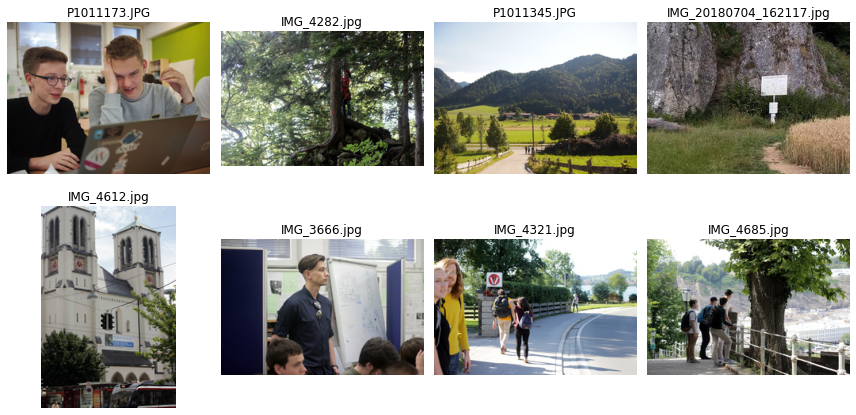

In [17]:
def visualize_dataset(dataset_dir: Path, n_rows=2, n_cols=4):
    n_samples = n_rows * n_cols
    paths = collect_images_files(dataset_dir)
    shuffle(paths)
    figure, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 6))

    for ii, path in enumerate(paths[:n_samples]):
        image = io.imread(str(path))
        name = path.name

        ax.ravel()[ii].imshow(image)
        ax.ravel()[ii].set_title(name)
        ax.ravel()[ii].set_axis_off()

    plt.tight_layout()
    plt.show()


print("Training images")
visualize_dataset(config.dataset_dir)


In [18]:
train_transform = transforms.Compose([
    transforms.RandomCrop(size=128),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(degrees=90, scale=(0.8, 1.2), translate=(0.1, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

val_transform = transforms.Compose([
    transforms.RandomCrop(size=128),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Visualizing augmented dataset
Found images in ../data/preprocessed/universum-photos: 1254


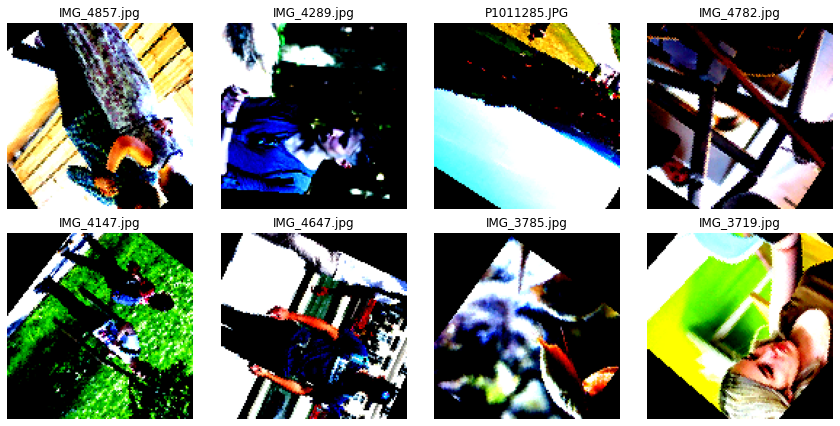

In [19]:
import torch


def visualize_augmented_dataset(dataset_dir: Path, transform, n_rows=2, n_cols=4):
    n_samples = n_rows * n_cols
    paths = collect_images_files(dataset_dir)
    shuffle(paths)
    figure, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 6))

    for ii, path in enumerate(paths[:n_samples]):
        image = Image.open(str(path))
        image = transform(image).permute(1, 2, 0).numpy()
        name = path.name

        ax.ravel()[ii].imshow(image)
        ax.ravel()[ii].set_title(name)
        ax.ravel()[ii].set_axis_off()

    plt.tight_layout()
    plt.show()


print("Visualizing augmented dataset")
visualize_augmented_dataset(config.dataset_dir, train_transform)


In [20]:
class ImageDataset(Dataset):
    def __init__(self, data_dir: Path, transform, train: bool, val_size: float):
        super(ImageDataset, self).__init__()
        assert data_dir.is_dir()

        self.paths = sorted(collect_images_files(data_dir))

        if train:
            self.paths, _ = train_test_split(self.paths, test_size=val_size, shuffle=True, random_state=0)
        else:
            _, self.paths = train_test_split(self.paths, test_size=val_size, shuffle=True, random_state=0)

        self.transform = transform

        self.to_grayscale = transforms.Grayscale()

    def __getitem__(self, item):
        image = Image.open(str(item))
        image = self.transform(image)
        gray_image = self.to_grayscale(image)
        return image, gray_image

    def __len__(self):
        return len(self.paths)


class ImageDataLoader(pl.LightningDataModule):
    def __init__(self, data_dir: Path, val_size: float, batch_size: int):
        super(ImageDataLoader, self).__init__()

        self.train_dataset = ImageDataset(data_dir, train_transform, train=True, val_size=val_size)
        self.val_dataset = ImageDataset(data_dir, val_transform, train=False, val_size=val_size)

        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(dataset=self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)


In [36]:

class EncoderBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: tuple = (3, 3)):
        super(EncoderBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(num_features=out_channels),
            nn.MaxPool2d(kernel_size=2)
        )

    def forward(self, x):
        x = self.block(x)
        print(f"encoder block size: {x.size()}")
        return x


class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()

        self.preprocess = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(num_features=64),
        )

        self.blocks = nn.Sequential(*[
            EncoderBlock(in_channels=64, out_channels=64),
            EncoderBlock(in_channels=64, out_channels=64),
            EncoderBlock(in_channels=64, out_channels=64),
            EncoderBlock(in_channels=64, out_channels=128)
        ])

    def forward(self, x):
        x = self.preprocess(x)
        x = self.blocks(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(DecoderBlock, self).__init__()

        self.module = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.LeakyReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Upsample(scale_factor=2),
        )

    def forward(self, x):
        x = self.module(x)
        print(f"decoder block size: {x.size()}")
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.blocks = nn.Sequential(
            DecoderBlock(in_channels=128, out_channels=64),
            DecoderBlock(in_channels=64, out_channels=64),
            DecoderBlock(in_channels=64, out_channels=64),
            DecoderBlock(in_channels=64, out_channels=64),
        )

        self.postprocess = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=(3, 3), padding=(1, 1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.blocks(x)
        x = self.postprocess(x)
        return x


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()


def forward(self, gray_image):
    encoded = self.encoder(gray_image)
    decoded = self.decoder(encoded)
    return decoded


decoder block size: torch.Size([1, 64, 16, 16])
decoder block size: torch.Size([1, 64, 32, 32])
decoder block size: torch.Size([1, 64, 64, 64])
decoder block size: torch.Size([1, 64, 128, 128])
torch.Size([1, 1, 128, 128])
